# Time series project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import networkx as nx
from collections import deque, OrderedDict

Useful function to calculate Laplacian and its conjugate.

In [2]:
def edge_list(p: int):
    """
    Returns list of (i,j) pairs with i>j in a fixed order.
    Length = p*(p-1)//2
    """
    edges = []
    for j in range(p):
        for i in range(j+1, p):
            edges.append((i, j))

    edges = np.array(edges)
    return edges

def L_operator(w: np.ndarray, p: int, edges=None) -> np.ndarray:
    """
    Laplacian operator L: 
    Builds Theta = Lw such that:
      Theta_ij = -w_k for (i,j) edge with i>j
      Theta is symmetric
      Theta_ii = -sum_{j!=i} Theta_ij  (so rows sum to 0)
    Matches Definition of Laplacian set S_Theta and operator L.  (paper Sec 3.1)

    See the paper for more information, specifically [page 13] !
    """

    if edges is None:
        edges = edge_list(p)
    m = p * (p - 1) // 2
    assert w.shape == (m,), f"w must have shape ({m},), got {w.shape}"

    Theta = np.zeros((p, p))
    for k, (i, j) in enumerate(edges):

        Theta[i, j] = -w[k]
        Theta[j, i] = -w[k]

    Theta[np.diag_indices(p)] = -Theta.sum(axis=1)

    return Theta

def L_adjoint(Y: np.ndarray, p: int, edges=None) -> np.ndarray:

    """
    Adjoint operator L*: 
    For each edge (i>j), returns:
      [L*Y]_k = Y_ii - Y_ij - Y_ji + Y_jj

    See paper for adjoint formula, specifically [page 14]
    """

    if edges is None:
        edges = edge_list(p)

    assert Y.shape == (p, p), f"Y must have shape ({p},{p}), got {Y.shape}"

    m = p * (p - 1) // 2
    out = np.zeros(m)

    for k, (i, j) in enumerate(edges):
        out[k] = Y[i, i] - Y[i, j] - Y[j, i] + Y[j, j]

    return out

def adjacency_from_theta(theta: np.ndarray):
    """
    For Laplacian Theta:
      off-diagonals are negative weights: Theta[i,j] = -w_ij
    """
    W = np.maximum(-theta, 0.0)
    thr = np.quantile(W[W > 0], 0.90)
    print(f"The threshold is: {thr}") 
    np.fill_diagonal(W, 0.0)
    W[W < thr] = 0.0
    return W

Test the correctess of the Adjoint and the Laplacian Matrix

In [3]:
p = 100
edges = edge_list(p)

m = p*(p-1)//2
w = np.arange(1, m+1)
Theta = L_operator(w, p, edges)
Y = np.random.randn(p, p)

left = np.sum(Theta * Y)  
right = np.dot(w, L_adjoint(Y, p, edges))
print("adjoint error:", np.isclose(left - right, 0), np.abs(left - right))

adjoint error: True 0.0


We can see that the scalar product is preserved, so the adjoint formula is correct. This part here plots the connected compoennt and shows the eigen values representing the numbe of connected compoenents.

Connected components (networkx): 3
Connected components (spectral): 3
Smallest eigenvalues: [-5.44104237e-15  1.55908272e-16  6.94820891e-15  1.83785233e+00
  1.97469415e+00  2.43899388e+00  2.47624090e+00  2.58502966e+00
  3.09072018e+00  3.21994196e+00]


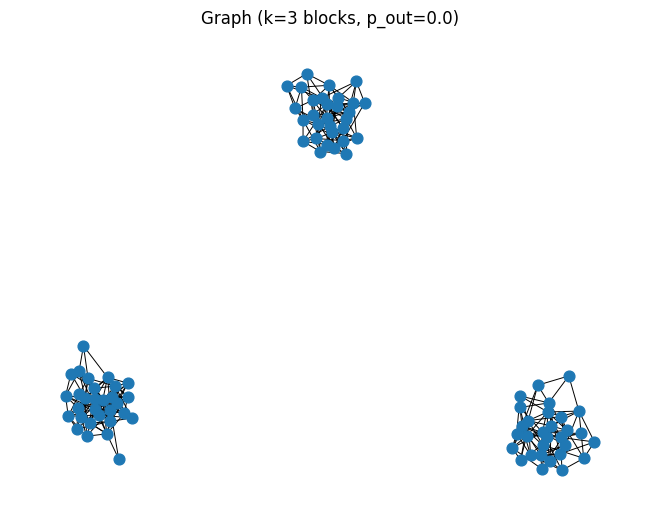

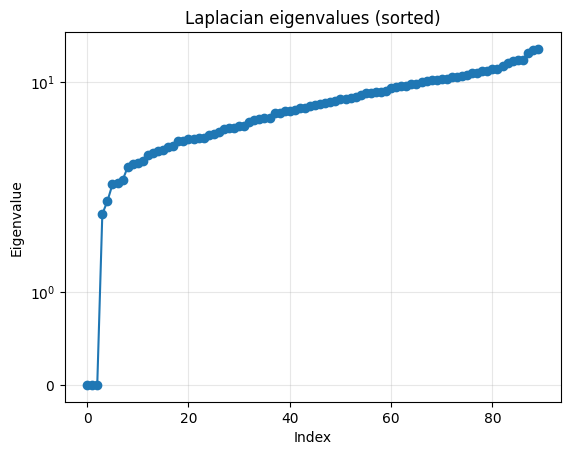

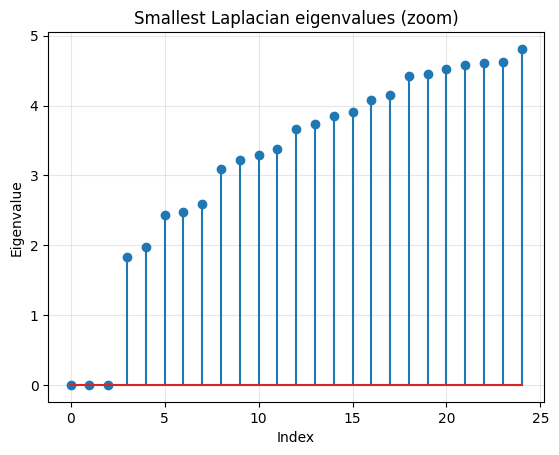

In [5]:
def laplacian_from_W(W: np.ndarray):
    """ Laplacian L = D - W.
    
        W : Adjacency matrix of the graph 
    """
    D = np.diag(W.sum(axis=1))
    return D - W

def normalized_laplacian_from_W(W: np.ndarray):

    """Normalized Laplacian L_sym = I - D^{-1/2} W D^{-1/2}."""
    
    d = W.sum(axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d))

    I = np.eye(W.shape[0])
    # Formula in tp altegrad
    return I - D_inv_sqrt @ W @ D_inv_sqrt

def count_components_from_eigs(eigs, tol=1e-8):
    """#components = multiplicity of eigenvalue 0 (within tolerance)."""
    return int(np.sum(eigs < tol))

# -----------------------------
# Generate a graph with k connected components
# -----------------------------
n_per = 30
k = 3
p_in = 0.25   
p_out = 0.0   

sizes = [n_per] * k
P = np.full((k, k), p_out)
np.fill_diagonal(P, p_in)

G = nx.stochastic_block_model(sizes, P)
W = nx.to_numpy_array(G, weight=None)
np.fill_diagonal(W, 0.0)

# -----------------------------
# Laplacian and eigenvalues
# -----------------------------
L = laplacian_from_W(W) 

eigs = np.linalg.eigvalsh(L)  
num_cc = nx.number_connected_components(G)
num_cc_from_spec = count_components_from_eigs(eigs, tol=1e-8)

print("Connected components (networkx):", num_cc)
print("Connected components (spectral):", num_cc_from_spec)
print("Smallest eigenvalues:", eigs[:10])

# -----------------------------
# Plot graph and eigenvalues
# -----------------------------
plt.figure()
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
plt.plot(eigs, marker="o")
plt.yscale("symlog")  
plt.title("Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
m = min(25, len(eigs))
plt.stem(range(m), eigs[:m])
plt.title("Smallest Laplacian eigenvalues (zoom)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()


In [139]:
def laplacian_from_W(W: np.ndarray):
    D = np.diag(W.sum(axis=1))
    return D - W

def sample_igmrf(Theta: np.ndarray, n: int, rng=None):
    """
    Sample x ~ N(0, Theta^\dagger), where Theta is a Laplacian (PSD, singular).
    Uses pseudo-inverse covariance.
    """
    if rng is None:
        rng = np.random.default_rng(0)
    Sigma = np.linalg.pinv(Theta)
    X = rng.multivariate_normal(mean=np.zeros(Theta.shape[0]), cov=Sigma, size=n)
    return X

def sample_covariance(X: np.ndarray):
    # matches (67) in the paper: centered sample covariance :contentReference[oaicite:6]{index=6}
    Xc = X - X.mean(axis=0, keepdims=True)
    return (Xc.T @ Xc) / Xc.shape[0]

In [ ]:
def weights_from_theta(Theta: np.ndarray, edges):
    # Theta_ij = -w_ij for i!=j, w>=0
    w = np.zeros(len(edges), dtype=float)
    for k, (i, j) in enumerate(edges):
        w[k] = max(-Theta[i, j], 0.0)
    return w

def relative_error(Theta_hat, Theta_true):
    return np.linalg.norm(Theta_hat - Theta_true, ord="fro") / (np.linalg.norm(Theta_true, ord="fro") + 1e-12)

def f_score_from_thetas(Theta_hat, Theta_true, edges, edge_thr=0.1):
    w_hat = weights_from_theta(Theta_hat, edges)
    w_true = weights_from_theta(Theta_true, edges)

    pred = (w_hat >= edge_thr)
    true = (w_true >= edge_thr)

    tp = np.sum(pred & true)
    fp = np.sum(pred & ~true)
    fn = np.sum(~pred & true)

    denom = (2*tp + fp + fn)
    return (2*tp / denom) if denom > 0 else 1.0

### SGL
SGL Algorithm, implemting the first algorithm of lambda and the correspinding second for updating the eigen values.

In [8]:
def phi_log(w, eps : float):
    return np.log(eps + w)

def sgl_objective(S: np.ndarray,
                  Lw: np.ndarray,
                  w: np.ndarray,
                  U: np.ndarray,
                  lam: np.ndarray,
                  alpha: float,
                  beta: float,
                  eps: float,
                  phi) -> float:
    """
    F(w,lam,U) =
      - log gdet(Diag(lam)) + tr(S Lw) + alpha * sum_i phi(w_i)
      + (beta/2) * ||Lw - U Diag(lam) U^T||_F^2
    """
    lam = np.asarray(lam, dtype=float)
    if np.any(lam <= 0):
        return np.inf  

    term_gdet = -np.sum(np.log(lam))                 
    term_trace = float(np.trace(S @ Lw))             
    term_sparse = float(alpha * np.sum(phi(w, eps)))      

    B = U @ np.diag(lam) @ U.T
    term_pen = 0.5 * beta * (np.linalg.norm(Lw - B, ord="fro") ** 2)

    return term_gdet + term_trace + term_sparse + term_pen

In [146]:
def w_init_naive_from_S(S: np.ndarray, edges: np.ndarray) -> np.ndarray:
    """
    Repo's 'naive' init: w_ij = max(0, -pinv(S)_{ij})
    """
    Sinv = np.linalg.pinv(S)
    m = len(edges)
    w0 = np.zeros(m, dtype=float)
    for e, (i, j) in enumerate(edges):
        w0[e] = max(-Sinv[i, j], 0.0)
    # small epsilon to avoid degenerate Lw at start (optional)
    w0 += 1e-12
    return w0

In [ ]:
def U_update(Lw: np.ndarray, k: int):
    evals, evecs = np.linalg.eigh(Lw)
    return evecs[:, k:], evals

In [148]:
def lambda_update_closed_form(d: np.ndarray, beta: float, c1: float, c2: float):
    d = np.asarray(d, dtype=float)
    lam = 0.5 * (d + np.sqrt(d*d + 4.0/beta))
    lam = np.clip(lam, c1, c2)

    # repo guardrail: lambda must be nondecreasing
    if np.any(np.diff(lam) < -1e-9):
        raise ValueError("lambda not nondecreasing; increase beta.")
    return lam

In [149]:
def apply_M(v: np.ndarray, p: int, edges: np.ndarray) -> np.ndarray:
    """
    M v = L*(L(v)), where L(v) is a Laplacian built from weight-vector v.
    """
    Lv = L_operator(v, p, edges)
    return L_adjoint(Lv, p, edges)

In [150]:
def w_update_repo_style(w: np.ndarray, Lw: np.ndarray, U: np.ndarray, lam: np.ndarray,
                        beta: float, K: np.ndarray, p: int, edges: np.ndarray) -> np.ndarray:
    """
    Mirrors R's laplacian.w_update:
      c = L*(U diag(lam) U^T - K/beta)
      grad_f = L*(Lw) - c
      t = (w^T M grad_f - c^T grad_f) / (grad_f^T M grad_f)
      w <- (w - t grad_f)_+
    """
    ULmdUT = U @ np.diag(lam) @ U.T
    c = L_adjoint(ULmdUT - (K / beta), p, edges)

    grad_f = L_adjoint(Lw, p, edges) - c
    M_grad_f = apply_M(grad_f, p, edges)

    denom = float(np.dot(grad_f, M_grad_f))
    if denom <= 1e-18 or not np.isfinite(denom):
        return np.maximum(w, 0.0)

    numer = float(np.dot(w, M_grad_f) - np.dot(c, grad_f))
    t = numer / denom

    w_new = np.maximum(w - t * grad_f, 0.0)
    return w_new

In [152]:
def sgl_r_style(S: np.ndarray,
                k: int,
                beta: float = 400.0,
                alpha: float = 0.1,
                eps: float = 1e-4,
                c1: float = 1e-9,
                c2: float = 1e9,
                maxiter: int = 200,
                reltol: float = 1e-6,
                w0: np.ndarray | None = None,
                verbose: bool = True):

    S = np.asarray(S, dtype=float)
    p = S.shape[0]
    edges = edge_list(p)
    m = len(edges)

    # ---- init w ----
    if w0 is None:
        w = w_init_naive_from_S(S, edges)   # IMPORTANT
    else:
        w = np.maximum(np.asarray(w0, dtype=float).copy(), 0.0)

    # H and K (reweighted l1 surrogate) like repo
    H = alpha * (np.eye(p) - np.ones((p, p)))

    # initial Lw, U, lam
    Lw = L_operator(w, p, edges)
    U, evals = U_update(Lw, k)
    d = np.diag(U.T @ Lw @ U)
    lam = lambda_update_closed_form(d, beta=beta, c1=c1, c2=c2)

    # K update (safe division)
    denom = (-Lw + eps)
    K = S + np.divide(H, denom, out=np.zeros_like(H), where=np.abs(denom) > 0)

    hist = {"relchg_w": [], "penalty": [], "eig_k": [], "step": []}

    for it in range(maxiter):
        w_old = w.copy()

        # ----- w-update (repo style) -----
        w = w_update_repo_style(w, Lw, U, lam, beta, K, p, edges)

        # ----- update Lw, U, lam -----
        Lw = L_operator(w, p, edges)
        U, evals = U_update(Lw, k)
        d = np.diag(U.T @ Lw @ U)
        lam = lambda_update_closed_form(d, beta=beta, c1=c1, c2=c2)

        # ----- update K (safe) -----
        denom = (-Lw + eps)
        K = S + np.divide(H, denom, out=np.zeros_like(H), where=np.abs(denom) > 0)

        # ----- logging / stopping -----
        relchg = np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12)
        hist["relchg_w"].append(relchg)
        hist["penalty"].append(np.linalg.norm(Lw - U @ np.diag(lam) @ U.T, ord="fro"))
        hist["eig_k"].append(evals[k] if k < len(evals) else np.nan)

        if verbose and (it % 10 == 0 or it == maxiter - 1):
            print(f"[it={it:03d}] relchg(w)={relchg:.3e}, eig[k]={hist['eig_k'][-1]:.3e}")

        if relchg < reltol:
            break

    return Lw, w, U, lam, hist

Application to noisy graphs

In [153]:
def make_block_k_component_laplacian(p=64, k=4, w_low=0.0, w_high=1.0, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    sizes = [p // k] * k
    assert sum(sizes) == p

    W_true = np.zeros((p, p), dtype=float)
    start = 0
    for sz in sizes:
        idx = np.arange(start, start + sz)
        W = rng.uniform(w_low, w_high, size=(sz, sz))
        W = 0.5 * (W + W.T)
        np.fill_diagonal(W, 0.0)
        W_true[np.ix_(idx, idx)] = W
        start += sz

    Theta_true = laplacian_from_W(W_true)
    return W_true, Theta_true

def make_er_noise_laplacian(p=64, p_edge=0.25, kappa=0.45, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    M = (rng.random((p, p)) < p_edge).astype(float)
    M = np.triu(M, 1)
    M = M + M.T

    W_er = rng.uniform(0.0, kappa, size=(p, p))
    W_er = 0.5 * (W_er + W_er.T)
    np.fill_diagonal(W_er, 0.0)
    W_er = M * W_er

    Theta_er = laplacian_from_W(W_er)
    return W_er, Theta_er


[it=000] relchg(w)=1.426e-02, eig[k]=2.085e+01
[it=010] relchg(w)=8.248e-03, eig[k]=1.850e+01
[it=020] relchg(w)=5.686e-03, eig[k]=1.741e+01
[it=030] relchg(w)=4.147e-03, eig[k]=1.682e+01
[it=040] relchg(w)=3.378e-03, eig[k]=1.636e+01
[it=050] relchg(w)=2.649e-03, eig[k]=1.602e+01
[it=060] relchg(w)=2.227e-03, eig[k]=1.578e+01
[it=070] relchg(w)=1.856e-03, eig[k]=1.564e+01
[it=080] relchg(w)=1.542e-03, eig[k]=1.554e+01
[it=090] relchg(w)=1.347e-03, eig[k]=1.545e+01
[it=100] relchg(w)=1.170e-03, eig[k]=1.538e+01
[it=110] relchg(w)=1.028e-03, eig[k]=1.532e+01
[it=120] relchg(w)=9.495e-04, eig[k]=1.526e+01
[it=130] relchg(w)=8.644e-04, eig[k]=1.522e+01
[it=140] relchg(w)=7.712e-04, eig[k]=1.519e+01
[it=150] relchg(w)=7.346e-04, eig[k]=1.516e+01
[it=160] relchg(w)=6.474e-04, eig[k]=1.513e+01
[it=170] relchg(w)=6.125e-04, eig[k]=1.510e+01
[it=180] relchg(w)=5.622e-04, eig[k]=1.508e+01
[it=190] relchg(w)=5.493e-04, eig[k]=1.505e+01
[it=200] relchg(w)=4.996e-04, eig[k]=1.503e+01
[it=210] relc

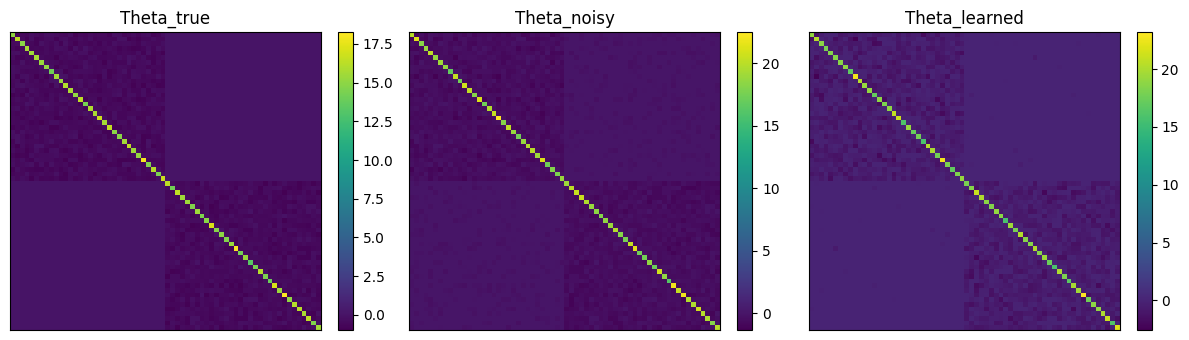

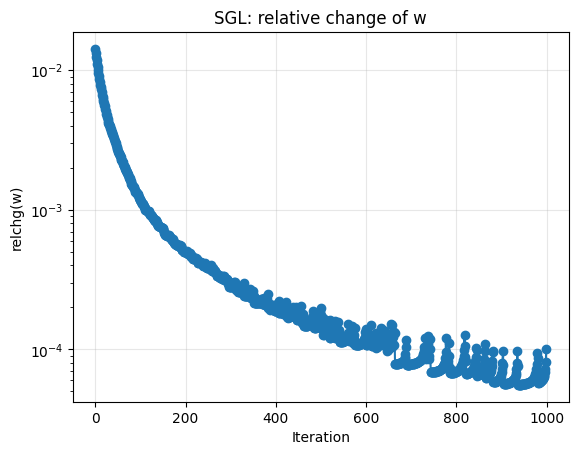

In [158]:
rng = np.random.default_rng(1)

p = 64
k_true = 2

# true multi-component Laplacian
W_true, Theta_true = make_block_k_component_laplacian(p=p, k=k_true, w_low=0.0, w_high=1.0, rng=rng)

# ER noise Laplacian (paper uses this corruption model)
W_er, Theta_er = make_er_noise_laplacian(p=p, p_edge=0.25, kappa=0.45, rng=rng)

Theta_noisy = Theta_true + Theta_er

# sample data from IGMRF and compute SCM (eq. 67)
n = 30 * p
X = sample_igmrf(Theta_noisy, n=n, rng=rng)
S = sample_covariance(X)

# run SGL (paper-like hyperparams for this scenario)
Theta_hat, w_hat, U_hat, lam_hat, hist = sgl_r_style(
    S, k=k_true,
    beta=400.0, alpha=0.1, eps=1e-4,
    c1=1e-9, c2=1e9,
    maxiter=1000, reltol=1e-6,
    verbose=True
)

# metrics
edges = edge_list(p)
re = relative_error(Theta_hat, Theta_true)
fs = f_score_from_thetas(Theta_hat, Theta_true, edges, edge_thr=0.1)
print(f"\nRE={re:.3f}, F-score={fs:.3f}")

# plots: heatmaps like the paper
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
for ax, M, title in zip(
    axes,
    [Theta_true, Theta_noisy, Theta_hat],
    ["Theta_true", "Theta_noisy", "Theta_learned"]
):
    im = ax.imshow(M, aspect="auto")
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    fig.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout()
plt.show()

# convergence diagnostics
plt.figure()
plt.semilogy(hist["relchg_w"], marker="o")
plt.title("SGL: relative change of w")
plt.xlabel("Iteration")
plt.ylabel("relchg(w)")
plt.grid(True, alpha=0.3)
plt.show()


In [159]:
def adjacency_from_theta(Theta: np.ndarray, thr_quantile: float = 0.90) -> np.ndarray:
    """
    Recover adjacency matrix W from Laplacian Theta.
    Threshold by quantile on positive weights.
    """
    # off-diagonal weights
    W = np.maximum(-Theta, 0.0)
    np.fill_diagonal(W, 0.0)

    # threshold (to visualize / binarize structure)
    positive = W[W > 0]
    if positive.size == 0:
        return W

    thr = np.quantile(positive, thr_quantile)
    print(f"[adjacency_from_theta] threshold = {thr:.4g}")

    W[W < thr] = 0.0
    return W

[adjacency_from_theta] threshold = 1.305


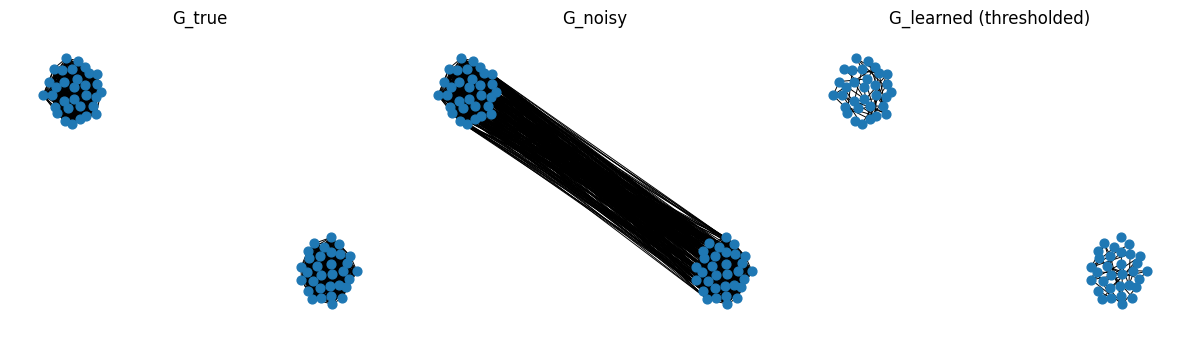

In [160]:
W_hat = adjacency_from_theta(Theta_hat, thr_quantile=0.90)

G_true = nx.from_numpy_array(np.maximum(W_true, 0.0))
G_noisy = nx.from_numpy_array(np.maximum(W_true + W_er, 0.0))
G_hat = nx.from_numpy_array(np.maximum(W_hat, 0.0))

pos = nx.spring_layout(G_true, seed=0)

plt.figure(figsize=(12, 3.5))

plt.subplot(1, 3, 1)
nx.draw(G_true, pos, node_size=40, width=0.7)
plt.title("G_true")
plt.axis("off")

plt.subplot(1, 3, 2)
nx.draw(G_noisy, pos, node_size=40, width=0.7)
plt.title("G_noisy")
plt.axis("off")

plt.subplot(1, 3, 3)
nx.draw(G_hat, pos, node_size=40, width=0.7)
plt.title("G_learned (thresholded)")
plt.axis("off")

plt.tight_layout()
plt.show()


### Animal Dataset

In [161]:
A_animals = np.loadtxt("./AwA2-base/Animals_with_Attributes2/predicate-matrix-binary.txt")  
with open("./AwA2-base/Animals_with_Attributes2/classes.txt", "r") as f:
    class_names = [line.strip() for line in f]

In [162]:
A_animals = np.asarray(A_animals)
print("A_animals shape:", A_animals.shape)

# convention: rows=features, cols=animals? you used transpose so keep same
X_animals = A_animals.T

mu = X_animals.mean(axis=0, keepdims=True)
std = X_animals.std(axis=0, keepdims=True)
std = np.maximum(std, 1e-12)          # avoid divide-by-zero

Xz = (X_animals - mu) / std

S_animals = (Xz.T @ Xz) / Xz.shape[0]
p = S_animals.shape[0]
print("S_animals shape:", S_animals.shape)

# small diagonal loading (like you did)
S_in_animals = S_animals + (1/3) * np.eye(p)

A_animals shape: (50, 85)
S_animals shape: (50, 50)


In [176]:
Theta_hat_animals, w_hat, U_hat, lam_hat, hist = sgl_r_style(
    S_in_animals,
    k=6,
    alpha=0.0,
    beta=1e4,
    eps=1e-3,
    c1=1e-3,
    c2=1e3,
    reltol=1e-6,
    maxiter=1000,
    verbose=True
)
W_hat_animals = adjacency_from_theta(Theta_hat_animals, thr_quantile=0.90)

[it=000] relchg(w)=3.904e-02, eig[k]=1.936e+00
[it=010] relchg(w)=1.608e-02, eig[k]=1.313e+00
[it=020] relchg(w)=8.588e-03, eig[k]=1.057e+00
[it=030] relchg(w)=6.621e-03, eig[k]=9.220e-01
[it=040] relchg(w)=5.106e-03, eig[k]=8.461e-01
[it=050] relchg(w)=3.803e-03, eig[k]=7.905e-01
[it=060] relchg(w)=2.813e-03, eig[k]=7.566e-01
[it=070] relchg(w)=2.291e-03, eig[k]=7.209e-01
[it=080] relchg(w)=1.964e-03, eig[k]=6.841e-01
[it=090] relchg(w)=1.541e-03, eig[k]=6.484e-01
[it=100] relchg(w)=1.423e-03, eig[k]=6.146e-01
[it=110] relchg(w)=9.912e-04, eig[k]=5.987e-01
[it=120] relchg(w)=9.437e-04, eig[k]=5.902e-01
[it=130] relchg(w)=8.953e-04, eig[k]=5.820e-01
[it=140] relchg(w)=8.184e-04, eig[k]=5.744e-01
[it=150] relchg(w)=7.768e-04, eig[k]=5.671e-01
[it=160] relchg(w)=7.137e-04, eig[k]=5.601e-01
[it=170] relchg(w)=6.732e-04, eig[k]=5.534e-01
[it=180] relchg(w)=6.311e-04, eig[k]=5.471e-01
[it=190] relchg(w)=5.877e-04, eig[k]=5.412e-01
[it=200] relchg(w)=5.433e-04, eig[k]=5.357e-01
[it=210] relc

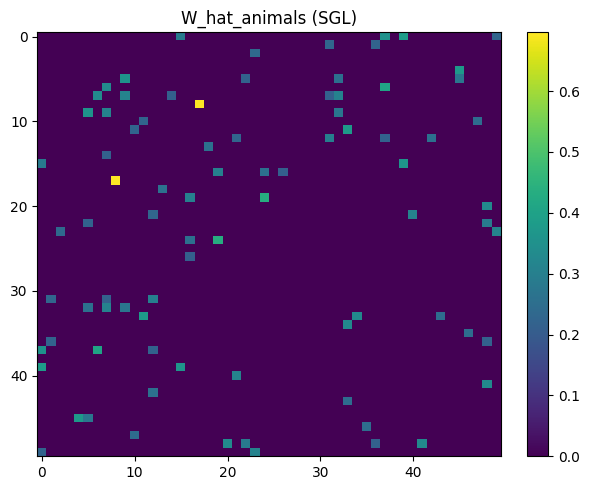

In [177]:
plt.figure(figsize=(6,5))
plt.imshow(W_hat_animals, aspect="auto")
plt.title("W_hat_animals (SGL)")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

In [178]:
W_hat_animals = adjacency_from_theta(Theta_hat_animals)
G_hat_animals = nx.from_numpy_array(W_hat_animals)

[adjacency_from_theta] threshold = 0.2119


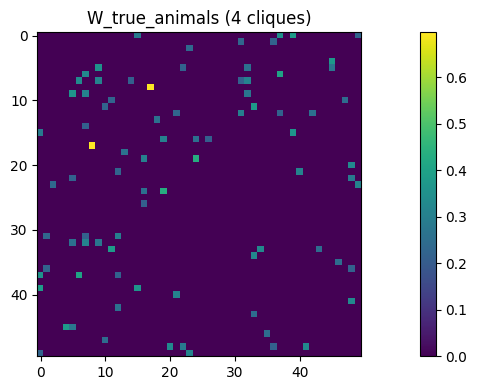

In [179]:
plt.figure(figsize=(12,4))


plt.imshow(W_hat_animals)
plt.title("W_true_animals (4 cliques)")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

In [180]:
print("Learned components (nx):", nx.number_connected_components(G_hat_animals))

Learned components (nx): 14


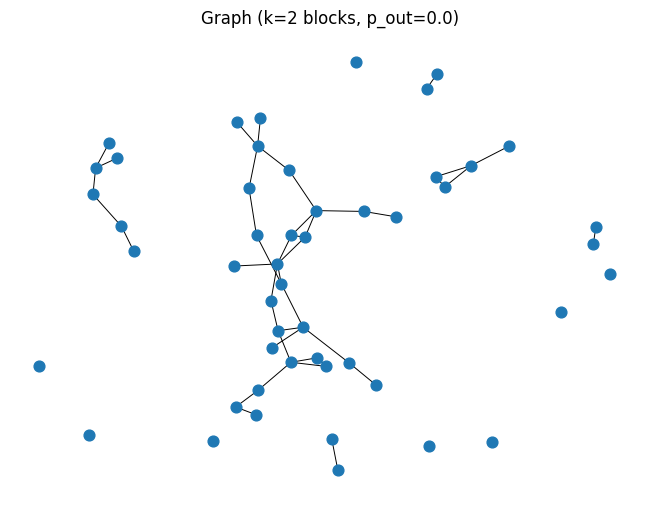

In [181]:
plt.figure()
pos = nx.spring_layout(G_hat_animals)
nx.draw(G_hat_animals, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k_true} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

### Moons, circles and clusters

In [182]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

X_moons, labels_true_moons = make_moons(
    n_samples=100,
    noise=0.05,
    random_state=0
)


X_circles, labels_true_circles = make_circles(
    n_samples=200,
    factor=0.05,
    noise=0.05,
    random_state=0
)


def gaussian_similarity(X, sigma=None):

    D = cdist(X, X, metric="euclidean")
    
    if sigma is None:
        sigma = np.median(D[D > 0]) * 0.2

    W = np.exp(-(D * D) / (2 * (sigma*sigma)))
    np.fill_diagonal(W, 0.0)
    
    return W

def knn_sparsify(W, k):

    p = W.shape[0]
    Wk = np.zeros_like(W)
    
    for i in range(p):
        idx = np.argsort(W[i])[-k:]
        Wk[i, idx] = W[i, idx]
    
    return np.maximum(Wk, Wk.T)

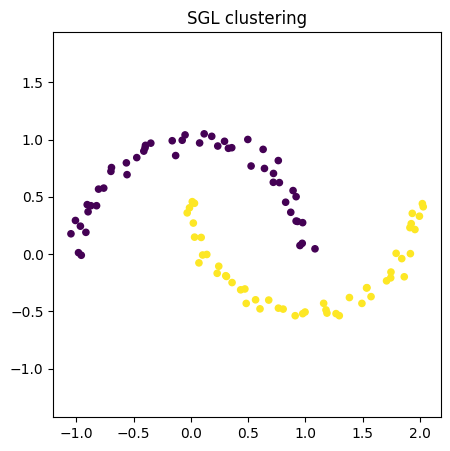

In [183]:
plt.figure(figsize=(5,5))
plt.scatter(X_moons[:,0], X_moons[:,1], c=labels_true_moons, s=20)
plt.title("SGL clustering")
plt.axis("equal")
plt.show()

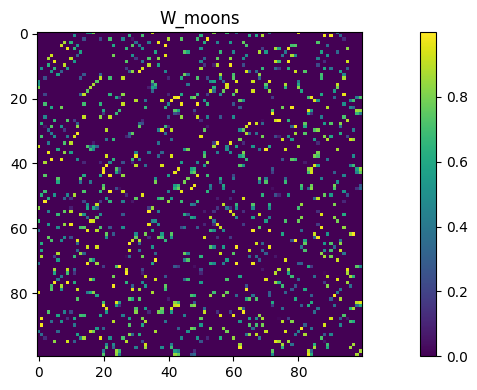

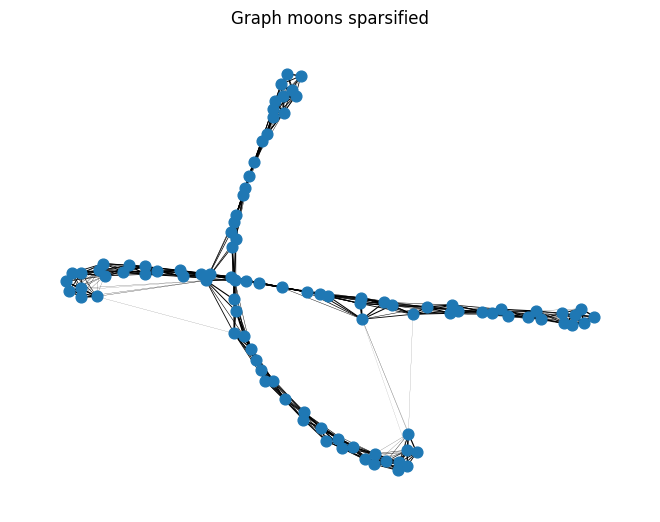

In [184]:
W_moons = gaussian_similarity(X_moons)
W_moons = knn_sparsify(W_moons, k=10)
G_moons = nx.from_numpy_array(W_moons)

plt.figure(figsize=(12,4))


plt.imshow(W_moons)
plt.title("W_moons")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_moons = nx.spring_layout(G_moons)
edges = list(G_moons.edges())
p = W_moons.shape[0]
weights = np.array([G_moons[u][v]["weight"] for u, v in edges])

nx.draw(G_moons, pos_moons, node_size=60, width=weights, edgelist=edges)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

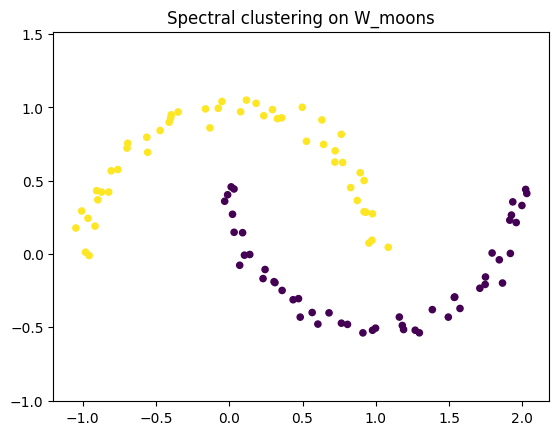

In [185]:
from sklearn.cluster import SpectralClustering

labels_sc = SpectralClustering(
    n_clusters=2,
    affinity="precomputed",
    random_state=0
).fit_predict(W_moons)

plt.scatter(X_moons[:,0], X_moons[:,1], c=labels_sc, s=20)
plt.axis("equal")
plt.title("Spectral clustering on W_moons")
plt.show()

In [192]:
p = W_moons.shape[0]
S_moons = W_moons + (1/3) * np.eye(p)

Theta_hat_moons, w_hat_moons, U_hat_moons, lam_hat_mooons, _ = sgl_r_style(
    S=S_moons,
    k=2,
    alpha=0.0,     
    beta=400.0,
    eps=1e-3,
    c1=1e-5,
    c2=1e5,
    reltol=1e-5,
    maxiter=1000,
)

[it=000] relchg(w)=7.551e-04, eig[k]=1.745e+00
[it=010] relchg(w)=1.380e-04, eig[k]=1.748e+00
[it=020] relchg(w)=9.083e-05, eig[k]=1.752e+00
[it=030] relchg(w)=7.656e-05, eig[k]=1.756e+00
[it=040] relchg(w)=6.662e-05, eig[k]=1.760e+00
[it=050] relchg(w)=5.852e-05, eig[k]=1.764e+00
[it=060] relchg(w)=5.205e-05, eig[k]=1.768e+00
[it=070] relchg(w)=4.702e-05, eig[k]=1.772e+00
[it=080] relchg(w)=4.321e-05, eig[k]=1.776e+00
[it=090] relchg(w)=4.041e-05, eig[k]=1.780e+00
[it=100] relchg(w)=3.627e-05, eig[k]=1.784e+00
[it=110] relchg(w)=3.590e-05, eig[k]=1.788e+00
[it=120] relchg(w)=3.562e-05, eig[k]=1.791e+00
[it=130] relchg(w)=3.543e-05, eig[k]=1.795e+00
[it=140] relchg(w)=3.533e-05, eig[k]=1.799e+00
[it=150] relchg(w)=3.532e-05, eig[k]=1.803e+00
[it=160] relchg(w)=3.540e-05, eig[k]=1.807e+00
[it=170] relchg(w)=3.558e-05, eig[k]=1.810e+00
[it=180] relchg(w)=3.584e-05, eig[k]=1.814e+00
[it=190] relchg(w)=3.621e-05, eig[k]=1.818e+00
[it=200] relchg(w)=3.669e-05, eig[k]=1.822e+00
[it=210] relc

In [195]:
W_hat_moons = adjacency_from_theta(Theta_hat_moons)
G_hat_moons = nx.from_numpy_array(W_hat_moons)

[adjacency_from_theta] threshold = 0.5608


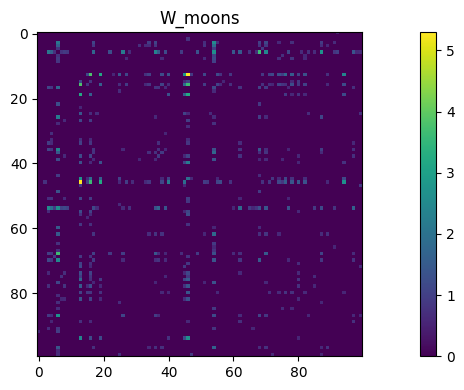

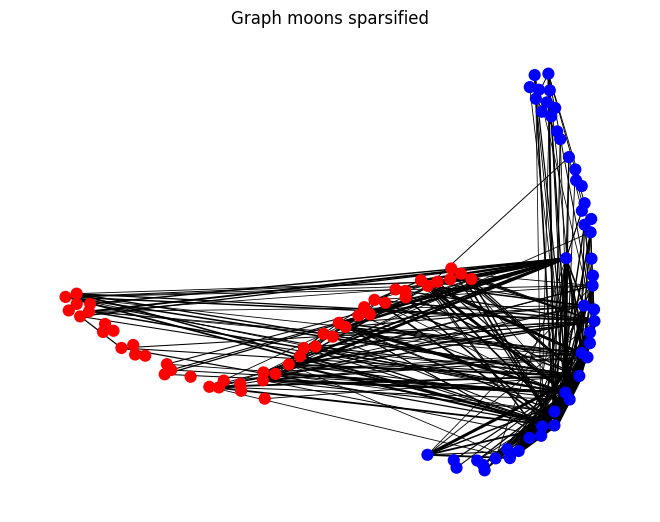

In [200]:
color_map = list()
for label in labels_true_moons:
    if label == 1:
        color_map.append('red')
    else :
        color_map.append('blue')

color_map = np.array(color_map)

plt.figure(figsize=(12,4))

plt.imshow(W_hat_moons)
plt.title("W_moons")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_moons = nx.spring_layout(G_moons)
edges = list(G_hat_moons.edges())
p = W_hat_moons.shape[0]
weights = np.array([G_hat_moons[u][v]["weight"] for u, v in edges])

nx.draw(G_hat_moons, pos_moons, node_size=60, width=weights, edgelist=edges, node_color=color_map)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

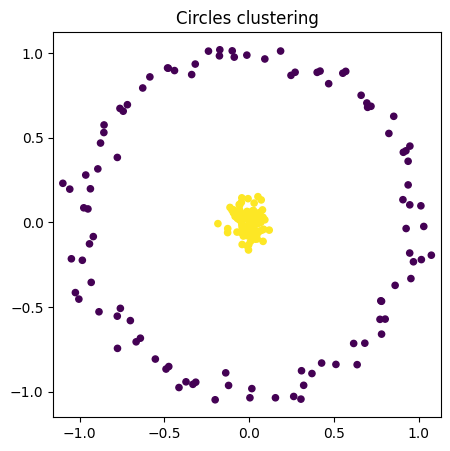

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(X_circles[:,0], X_circles[:,1], c=labels_true_circles, s=20)
plt.title("Circles clustering")
plt.axis("equal")
plt.show()

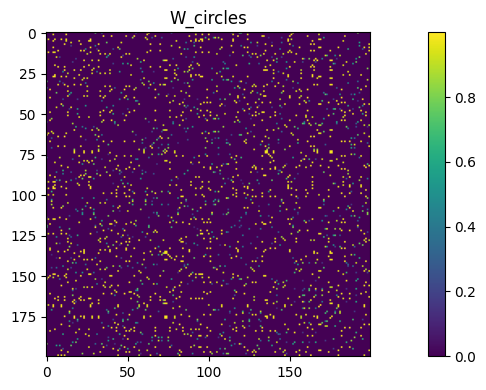

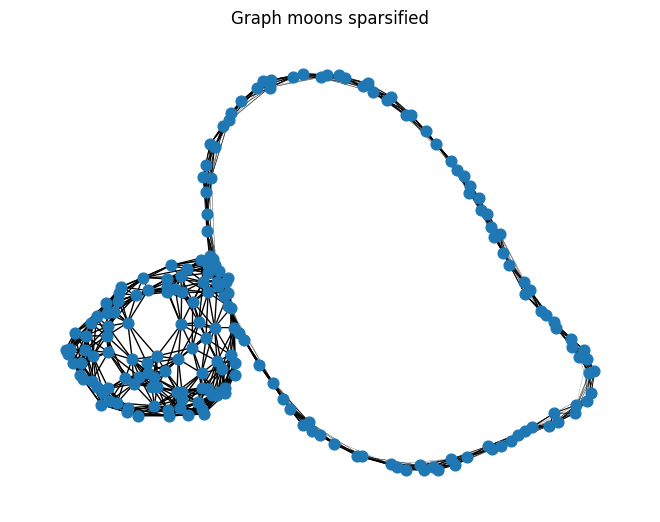

In [ ]:
W_circles = gaussian_similarity(X_circles)
W_circles = knn_sparsify(W_circles, k=10)
G_circles = nx.from_numpy_array(W_circles)

plt.figure(figsize=(12,4))


plt.imshow(W_circles)
plt.title("W_circles")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_circles = nx.spring_layout(G_circles)
edges_circles = list(G_circles.edges())
p = W_circles.shape[0]
weights_circles = np.array([G_circles[u][v]["weight"] for u, v in edges_circles])

nx.draw(G_circles, pos_circles, node_size=60, width=weights_circles, edgelist=edges_circles)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

In [ ]:
p = W_circles.shape[0]
S_circles = W_circles + (1/3) * np.eye(p)

Theta_hat_circles, w_hat_circles, U_hat_circles, lam_hat_circles = sgl(
    S=S_circles,
    k=2,
    alpha=0.0,     
    beta=100.0,
    eps=1e-3,
    c1=1e-5,
    c2=1e5,
    tol=1e-5,
    patience=50,
    l1 = 50.0,
)

the best relative error is: 0.001295722693988751
the relative error is: 0.001295722693988751
the relative error is: 0.0016562639154744621
the relative error is: 0.0013535037961760921
the best relative error is: 0.001273866010542486
the best relative error is: 0.001248366903985152
the best relative error is: 0.0012233743652738448
the best relative error is: 0.0011988785596326282
the best relative error is: 0.0011748698297354043
the best relative error is: 0.0011513386933178957
the best relative error is: 0.0011282758407688465
the best relative error is: 0.0011056721327050156
the relative error is: 0.0011056721327050156
the best relative error is: 0.0010835185975341646
the best relative error is: 0.0010618064290098433
the best relative error is: 0.0010405269837815072
the best relative error is: 0.0010196717789432042
the best relative error is: 0.000999232489583774
the best relative error is: 0.000979200946341321
the best relative error is: 0.0009595691329644639
the best relative error is

In [ ]:
W_hat_circles = adjacency_from_theta(Theta_hat_circles)
G_hat_circles = nx.from_numpy_array(W_hat_circles)

The threshold is: 0.1000341405339621


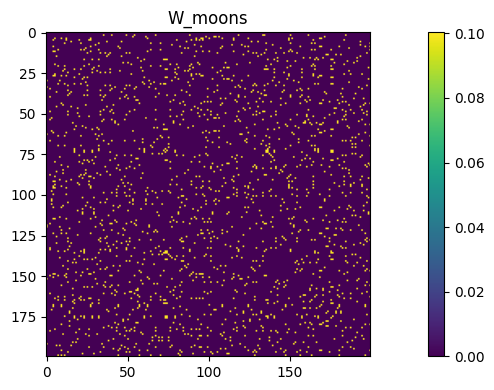

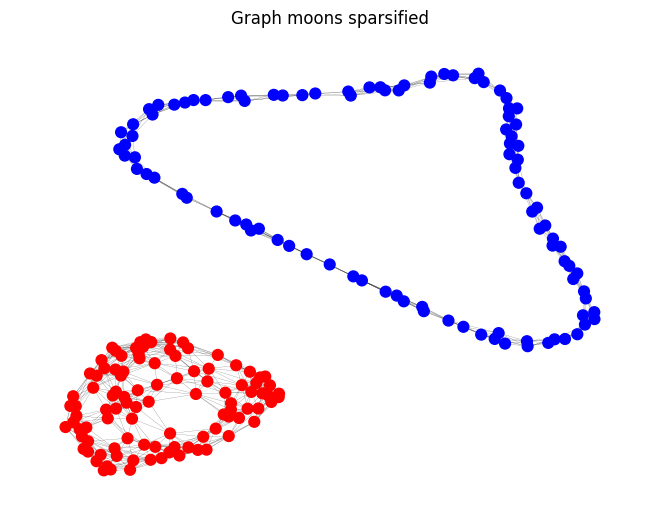

In [ ]:
color_map = list()
for label in labels_true_circles:
    if label == 1:
        color_map.append('red')
    else :
        color_map.append('blue')

color_map = np.array(color_map)

plt.figure(figsize=(12,4))

plt.imshow(W_hat_circles)
plt.title("W_moons")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_circles = nx.spring_layout(G_circles)
edges_circles = list(G_hat_circles.edges())
p = W_hat_circles.shape[0]
weights_circles = np.array([G_hat_circles[u][v]["weight"] for u, v in edges_circles])

nx.draw(G_hat_circles, pos_circles, node_size=60, width=weights_circles, edgelist=edges_circles, node_color=color_map)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

### SGA Algorithm

In [ ]:
def laplacian_from_W(W: np.ndarray):
    D = np.diag(W.sum(axis=1))
    return D - W

def count_components_from_eigs(eigs, tol=1e-8):
    return int(np.sum(eigs < tol))

Adjacency algorithm

In [ ]:
def A_operator(w: np.ndarray, p: int, edges=None):
    """
    Adjacency operator A : w -> W = Aw
    Off-diagonal: W_ij = w_k, diag = 0 (See page 19)
    """

    if edges is None:
        edges = edge_list(p)
        
    W = np.zeros((p, p), dtype=float)
    
    for wk, (i, j) in zip(w, edges):

        W[i, j] = wk
        W[j, i] = wk
    
    np.fill_diagonal(W, 0.0)

    return W

def A_adjoint(Y: np.ndarray, p: int, edges=None):
    """
    Adjoint A* : Y -> vector where each entry is Y_ij + Y_ji (See paper page 19)
    """

    if edges is None:
        edges = edge_list(p)

    out = np.zeros(len(edges), dtype=float)
    
    for k, (i, j) in enumerate(edges):
        out[k] = Y[i, j] + Y[j, i]
    
    return out

Testing the correctness of the adjacency operator.

In [ ]:
p = 4
edges = edge_list(p)

m = p*(p-1)//2
w = np.arange(1, m+1)
A = A_operator(w, p, edges)
Y = np.random.randn(p, p)

left = np.sum(A * Y)  
right = np.dot(w, A_adjoint(Y, p, edges))
print("adjoint error:", np.isclose(left - right, 0), np.abs(left - right))

adjoint error: True 0.0


In [ ]:
def V_from_Aw(Aw: np.ndarray, z: int):
        
        _, evecs = np.linalg.eigh(Aw)  
        a = (p - z) // 2
        b = (p + z) // 2
        
        V = np.concatenate([evecs[:, :a], evecs[:, b:]], axis=1)
        return V

In [ ]:
def update_psi_with_update_lambda(e, c1, c2, beta_lam):

        """
        Adaptation of the lambda Algo
        """

        e = np.asarray(e, float)
        b = e.size
        assert b % 2 == 0
        half = b // 2

        
        t = (e[:half] - e[::-1][:half]) / 2
        
        t_proj_inc = update_lambda(-t, beta=beta_lam, c1=-c1, c2=-c2)
        t_proj = -t_proj_inc

        psi = np.concatenate([t_proj, -t_proj[::-1]])
        return psi

In [ ]:
def sga(S: np.ndarray,
        alpha: float = 1e-3,
        gamma: float = 10.0,          
        beta: float = 50.0,       
        eps: float = 1e-5,
        c1: float = 1.0,              
        c2: float = 0.1,              
        z: int = 0,                   
        w0: np.ndarray | None = None,
        tol: float = 1e-5):      

    """
    SGA Algporithm

    Inputs (match paper):
      - S: sample covariance matrix (SCM)
      - k: number of connected components (k>=1), so q = p-k non-zero eigenvalues
      - c1, c2: bounds for non-zero Laplacian eigenvalues
      - beta: penalty parameter in relaxation
      - alpha: sparsity weight for reweighted l1 via log(eps + w_i)
      - eps: small positive number in log(eps + w_i)
      - w0: initialization for edge weights (nonnegative), length p(p-1)/2
      - stopping: relative change in w

    Returns:
      Theta: learned Laplacian matrix (p x p)
      w, U, lam: final iterates
    """       

    S = np.asarray(S, dtype=float)
    p = S.shape[0]
    assert S.shape == (p, p)

    edges = edge_list(p)
    m = len(edges)

    if w0 is None:
        w = 0.1 * np.ones(m, dtype=float)
    else:
        w = np.maximum(np.asarray(w0, dtype=float).copy(), 0.0)

    J = np.ones((p, p), dtype=float) / p
    L = 2.0 * p
   
    Aw = A_operator(w, p, edges)
    

    V = V_from_Aw(Aw, z=z)
    
    e = np.diag(V.T @ Aw @ V).copy()

    psi = update_psi_with_update_lambda(e, c1=c1, c2=c2, beta_lam=beta)

    while True:

        w_old = w.copy()

        Lmat = L_operator(w, p, edges)
        Aw = A_operator(w, p, edges)
        
        M = Lmat + J
        Minv = np.linalg.inv(M)
        grad_f1 = - (1.0 / gamma) * L_adjoint(Minv, p, edges)

        
        c_tilde = A_adjoint((V * psi) @ V.T, p, edges) - (1.0 / gamma) * L_adjoint(S, p, edges)
        grad_f2 = A_adjoint(Aw, p, edges) - c_tilde

        
        grad_f3 = (alpha / gamma) * (1.0 / (eps + w))

        grad = grad_f1 + grad_f2 + grad_f3
        w = np.maximum(w - (grad / L), 0.0)

        Aw = A_operator(w, p, edges)
        V = V_from_Aw(Aw, z=z)
 
        e = np.diag(V.T @ Aw @ V).copy()
        psi = update_psi_with_update_lambda(e, c1=c1, c2=c2, beta_lam=beta)

        if np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12) < tol:
            break


    Theta_hat = L_operator(w, p, edges)
    return Theta_hat, w, V, psi

### SGLA Algorithm

In [ ]:
def sgla(S: np.ndarray,
        k : int,
        alpha: float = 1e-3,
        gamma: float = 10.0,          
        beta: float = 50.0,       
        eps: float = 1e-5,
        c1: float = 1.0,              
        c2: float = 0.1,              
        z: int = 0,                   
        w0: np.ndarray | None = None,
        tol: float = 1e-5):      

    """
    SGA Algporithm

    Inputs (match paper):
      - S: sample covariance matrix (SCM)
      - k: number of connected components (k>=1), so q = p-k non-zero eigenvalues
      - c1, c2: bounds for non-zero Laplacian eigenvalues
      - beta: penalty parameter in relaxation
      - alpha: sparsity weight for reweighted l1 via log(eps + w_i)
      - eps: small positive number in log(eps + w_i)
      - w0: initialization for edge weights (nonnegative), length p(p-1)/2
      - stopping: relative change in w

    Returns:
      Theta: learned Laplacian matrix (p x p)
      w, U, lam: final iterates
    """       

    S = np.asarray(S, dtype=float)
    p = S.shape[0]
    assert S.shape == (p, p)

    edges = edge_list(p)
    m = len(edges)

    if w0 is None:
        w = 0.1 * np.ones(m, dtype=float)
    else:
        w = np.maximum(np.asarray(w0, dtype=float).copy(), 0.0)

    J = np.ones((p, p), dtype=float) / p
    L = 2 * (p * beta + gamma)

    Aw = A_operator(w, p, edges)
    Lw = L_operator(w, p, edges)

    V = V_from_Aw(Aw, z=z)
    _, U = np.linalg.eigh(Lw)
    U = U[:, k :]
    
    e = np.diag(V.T @ Aw @ V).copy()
    d = np.diag(U.T @ Lw @ U).copy()

    psi = update_psi_with_update_lambda(e, c1=c1, c2=c2, beta_lam=beta)
    lam = update_lambda(d, c1 = c1, c2 = c2, beta=beta)

    while True:

        w_old = w.copy()

        Lw = L_operator(w, p, edges)
        Aw = A_operator(w, p, edges)
        
        c_1 = beta * L_adjoint((U * lam) @ U.T - S / beta, p = p, edges=edges)
        c_2 = gamma * A_adjoint((V * psi) @ V.T, p = p, edges = edges)
        b_1 = alpha / (eps + w)

        grad_f1 = beta * L_adjoint(Lw, p = p, edges=edges) - c_1 + b_1
        grad_f2 = gamma * A_adjoint(Aw, p = p, edges = edges) - c_2

        grad = grad_f1 + grad_f2 
        w = np.maximum(w - (grad / L), 0.0)

        Aw = A_operator(w, p, edges)
        V = V_from_Aw(Aw, z=z)
        _, U = np.linalg.eigh(Lw)
        U = U[:, k :]

        d = np.diag(U.T @ Lw @ U).copy()
        e = np.diag(V.T @ Aw @ V).copy()
        psi = update_psi_with_update_lambda(e, c1=c1, c2=c2, beta_lam=beta)
        lam = update_lambda(d, c1 = c1, c2 = c2, beta = beta)

        if np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12) < tol:
            break

    Theta_hat = L_operator(w, p, edges)
    return Theta_hat, w, V, psi

In [131]:
import numpy as np

def make_edge_index(p: int):
    edges = []
    for i in range(p):
        for j in range(i+1, p):
            edges.append((i, j))
    return np.array(edges, dtype=int)  # (m,2)

def L_from_w(w: np.ndarray, p: int, edge_index: np.ndarray) -> np.ndarray:
    L = np.zeros((p, p), dtype=float)
    for e, (i, j) in enumerate(edge_index):
        wij = w[e]
        L[i, i] += wij
        L[j, j] += wij
        L[i, j] -= wij
        L[j, i] -= wij
    return L

def Lstar(X: np.ndarray, edge_index: np.ndarray) -> np.ndarray:
    # returns vector in R^m
    out = np.empty((edge_index.shape[0],), dtype=float)
    # assume X is symmetric (common in this algorithm); if not, use Xij+Xji
    for e, (i, j) in enumerate(edge_index):
        out[e] = X[i, i] + X[j, j] - 2.0 * X[i, j]
    return out

def U_update(Lw: np.ndarray, k: int) -> np.ndarray:
    evals, evecs = np.linalg.eigh(Lw)  # already sorted ascending
    return evecs[:, k:]  # p x (p-k)

def lambda_update(lb, ub, beta, U, Lw, k):
    p = Lw.shape[0]
    q = p - k
    d = np.diag(U.T @ Lw @ U)  # length q
    lam = 0.5 * (d + np.sqrt(d*d + 4.0/beta))
    lam = np.clip(lam, lb, ub)
    # monotonic check
    if np.any(np.diff(lam) < -1e-9):
        raise ValueError("lambda not nondecreasing; increase beta or check U/Lw")
    return lam

def w_update_laplacian(w, beta, lam, U, K, p, edge_index):
    Lw = L_from_w(w, p, edge_index)
    ULmdUT = U @ np.diag(lam) @ U.T
    c = Lstar(ULmdUT - K / beta, edge_index)

    grad_f = Lstar(Lw, edge_index) - c
    M_grad_f = Lstar(L_from_w(grad_f, p, edge_index), edge_index)

    wT_M_grad_f = np.dot(w, M_grad_f)
    dwT_M_dw = np.dot(grad_f, M_grad_f)
    if dwT_M_dw <= 1e-18:
        return np.maximum(w, 0.0)  # safeguard

    t = (wT_M_grad_f - np.dot(c, grad_f)) / dwT_M_dw
    w_new = w - t * grad_f
    w_new = np.maximum(w_new, 0.0)
    return w_new


In [136]:
import numpy as np
from dataclasses import dataclass
from typing import Optional, Dict, Any, List, Tuple, Union


# =========================
# Helpers: edges + operators
# =========================

def make_edge_index(p: int) -> np.ndarray:
    """All undirected edges (i<j) in a complete graph."""
    edges = [(i, j) for i in range(p) for j in range(i + 1, p)]
    return np.asarray(edges, dtype=np.int64)  # (m,2)


def L_from_w(w: np.ndarray, p: int, edge_index: np.ndarray) -> np.ndarray:
    """Combinatorial Laplacian L = D - A built from edge-weight vector w (i<j)."""
    L = np.zeros((p, p), dtype=float)
    for e, (i, j) in enumerate(edge_index):
        wij = float(w[e])
        if wij == 0.0:
            continue
        L[i, i] += wij
        L[j, j] += wij
        L[i, j] -= wij
        L[j, i] -= wij
    return L


def A_from_w(w: np.ndarray, p: int, edge_index: np.ndarray) -> np.ndarray:
    """Adjacency matrix A from edge-weight vector w (symmetric, zero diagonal)."""
    A = np.zeros((p, p), dtype=float)
    for e, (i, j) in enumerate(edge_index):
        wij = float(w[e])
        if wij == 0.0:
            continue
        A[i, j] = wij
        A[j, i] = wij
    return A


def Lstar(M: np.ndarray, edge_index: np.ndarray) -> np.ndarray:
    """
    Adjoint of Laplacian linear operator L(·).
    For symmetric M: (L* M)_{ij} = M_ii + M_jj - 2 M_ij for edge (i<j).
    """
    out = np.empty((edge_index.shape[0],), dtype=float)
    for e, (i, j) in enumerate(edge_index):
        out[e] = M[i, i] + M[j, j] - 2.0 * M[i, j]
    return out


def w_from_L_like(M: np.ndarray, edge_index: np.ndarray) -> np.ndarray:
    """
    Linv-like: extract edge weights from a Laplacian-like matrix:
    w_ij = -M_ij for i<j.
    (This matches Laplacian convention; for arbitrary M it's a heuristic.)
    """
    w = np.empty((edge_index.shape[0],), dtype=float)
    for e, (i, j) in enumerate(edge_index):
        w[e] = -float(M[i, j])
    return w


def eigvec_sym(M: np.ndarray) -> np.ndarray:
    """Eigenvectors of symmetric M, columns aligned with ascending eigenvalues."""
    _, V = np.linalg.eigh(M)
    return V


def eigval_sym(M: np.ndarray) -> np.ndarray:
    """Eigenvalues of symmetric M, ascending."""
    d, _ = np.linalg.eigh(M)
    return d


# =========================
# Build initial graph (Nie-style) for data matrix input
# =========================

def pairwise_sq_dists_rows(Y: np.ndarray) -> np.ndarray:
    """Squared Euclidean distances between rows of Y (p x n)."""
    # (x-y)^2 = x^2 + y^2 - 2xy
    G = Y @ Y.T
    s = np.sum(Y * Y, axis=1, keepdims=True)
    D2 = s + s.T - 2.0 * G
    # numerical cleanup
    np.maximum(D2, 0.0, out=D2)
    return D2


def build_initial_graph(Y: np.ndarray, m: int) -> np.ndarray:
    """
    Port of R build_initial_graph:
    for each node i, connect to m nearest neighbors with Nie et al. weights.
    Returns directed A (will be symmetrized later).
    """
    p = Y.shape[0]
    if m < 1 or m > p - 2:
        raise ValueError(f"m must satisfy 1 <= m <= p-2, got m={m}, p={p}")

    E = pairwise_sq_dists_rows(Y)
    A = np.zeros((p, p), dtype=float)

    for i in range(p):
        sorted_idx = np.argsort(E[i])  # includes i itself at position 0
        j_sweep = sorted_idx[1 : (m + 1)]
        j_mplus1 = sorted_idx[m + 1]  # (m+2)th in 1-based indexing, i excluded
        den = m * E[i, j_mplus1] - np.sum(E[i, j_sweep])
        ei = E[i, j_mplus1]

        # guard: if den is 0 (rare degeneracy), fall back to uniform weights
        if abs(den) < 1e-12:
            A[i, j_sweep] = 1.0 / m
            continue

        for j in j_sweep:
            A[i, j] = (ei - E[i, j]) / den

    return A


def laplacian_from_affinity(S: np.ndarray) -> np.ndarray:
    """LS = DS - 0.5 (S + S^T) as in the R code."""
    SS = 0.5 * (S + S.T)
    DS = np.diag(np.sum(SS, axis=1))
    return DS - SS


# =========================
# SGL pieces (laplacian.*)
# =========================

def laplacian_U_update(Lw: np.ndarray, k: int) -> np.ndarray:
    """U = eigenvectors excluding first k (k zero-eigs)."""
    V = eigvec_sym(Lw)  # columns sorted ascending
    return V[:, k:]


def laplacian_lambda_update(lb: float, ub: float, beta: float, U: np.ndarray, Lw: np.ndarray, k: int) -> np.ndarray:
    """
    Port of laplacian.lambda_update.
    lambda_i = 0.5 * (d_i + sqrt(d_i^2 + 4/beta)), then clip to [lb,ub] and check monotonicity.
    """
    p = Lw.shape[0]
    q = p - k
    d = np.diag(U.T @ Lw @ U)  # length q

    lam = 0.5 * (d + np.sqrt(d * d + 4.0 / beta))
    eps = 1e-9

    # fast accept if already feasible
    cond = [
        (lam[q - 1] - ub) <= eps,
        (lam[0] - lb) >= -eps,
        np.all(np.diff(lam) >= -eps),
    ]
    if all(cond):
        return lam

    # clip bounds then re-check order
    lam = np.clip(lam, lb, ub)
    cond2 = [
        (lam[q - 1] - ub) <= eps,
        (lam[0] - lb) >= -eps,
        np.all(np.diff(lam) >= -eps),
    ]
    if all(cond2):
        return lam

    raise ValueError("lambda not in increasing order after clipping; consider increasing beta (as repo suggests).")


def laplacian_negloglikelihood(Lw: np.ndarray, lam: np.ndarray, K: np.ndarray) -> float:
    # sum(-log(lambda)) + trace(K Lw)
    return float(np.sum(-np.log(lam)) + np.trace(K @ Lw))


def laplacian_prior(beta: float, Lw: np.ndarray, lam: np.ndarray, U: np.ndarray) -> float:
    ULmdUT = U @ np.diag(lam) @ U.T
    diff = Lw - ULmdUT
    return 0.5 * beta * float(np.sum(diff * diff))  # Frobenius^2


def laplacian_w_update(w: np.ndarray, Lw: np.ndarray, U: np.ndarray, beta: float,
                       lam: np.ndarray, K: np.ndarray, edge_index: np.ndarray) -> np.ndarray:
    """
    Port of laplacian.w_update from the repo:
      c = L*( U diag(lam) U^T - K/beta )
      grad_f = L*(Lw) - c
      exact line search t
      w <- P_+( w - t grad_f )
    """
    ULmdUT = U @ np.diag(lam) @ U.T
    c = Lstar(ULmdUT - (K / beta), edge_index)

    grad_f = Lstar(Lw, edge_index) - c  # edge-space gradient

    # M_grad_f = L*( L(grad_f) )
    p = Lw.shape[0]
    M_grad_f = Lstar(L_from_w(grad_f, p, edge_index), edge_index)

    wT_M_grad_f = float(np.dot(w, M_grad_f))
    dwT_M_dw = float(np.dot(grad_f, M_grad_f))

    if dwT_M_dw <= 1e-18 or not np.isfinite(dwT_M_dw):
        # Degenerate; just project current w
        return np.maximum(w, 0.0)

    t = (wT_M_grad_f - float(np.dot(c, grad_f))) / dwT_M_dw

    w_new = w - t * grad_f
    w_new = np.maximum(w_new, 0.0)
    return w_new


# =========================
# w_init (repo style)
# =========================

def w_init(w0: Union[str, np.ndarray], Sinv: np.ndarray, edge_index: np.ndarray) -> np.ndarray:
    """
    Repo w_init supports "qp" and "naive". Here we implement "naive" faithfully-ish.
    - "naive": w = Linv(Sinv); clip negatives to 0.
    If w0 is an array, returns it.
    """
    if isinstance(w0, str):
        if w0.lower() == "naive":
            w = w_from_L_like(Sinv, edge_index)
            w[w < 0.0] = 0.0
            return w
        elif w0.lower() == "qp":
            raise NotImplementedError(
                '"qp" init requires a QP solver and vecLmat; implement if you want exact repo behavior.'
            )
        else:
            raise ValueError(f"Unknown w0 method: {w0}")
    else:
        w = np.asarray(w0, dtype=float).copy()
        if w.ndim != 1:
            raise ValueError("w0 array must be 1D edge-weight vector.")
        w[w < 0.0] = 0.0
        return w


# =========================
# Main: learn_k_component_graph (SGL)
# =========================

@dataclass
class SGLResult:
    laplacian: np.ndarray
    adjacency: np.ndarray
    w: np.ndarray
    lam: np.ndarray
    U: np.ndarray
    elapsed_time: np.ndarray
    convergence: bool
    beta_seq: np.ndarray
    obj_fun: Optional[np.ndarray] = None
    negloglike: Optional[np.ndarray] = None
    w_seq: Optional[List[np.ndarray]] = None


def learn_k_component_graph(
    S: np.ndarray,
    *,
    is_data_matrix: bool = False,
    k: int = 1,
    w0: Union[str, np.ndarray] = "naive",
    lb: float = 0.0,
    ub: float = 1e4,
    alpha: float = 0.0,
    beta: float = 1e4,
    beta_max: float = 1e6,
    fix_beta: bool = True,
    rho: float = 1e-2,
    m: int = 7,
    eps: float = 1e-4,
    maxiter: int = 10_000,
    abstol: float = 1e-6,
    reltol: float = 1e-4,
    eigtol: float = 1e-9,
    record_objective: bool = False,
    record_weights: bool = False,
) -> SGLResult:
    """
    Python port of the repo's learn_k_component_graph (SGL / JMLR 2020 framework).

    Input S can be:
      - pxp covariance/correlation matrix (is_data_matrix=False)
      - pxn data matrix (is_data_matrix=True OR not square)
    """
    S = np.asarray(S, dtype=float)

    # If S is data matrix or not square: build affinity graph then pseudo-invert Laplacian as in repo.
    if is_data_matrix or (S.ndim == 2 and S.shape[0] != S.shape[1]):
        Y = S
        A0 = build_initial_graph(Y, m=m)
        SA = 0.5 * (A0 + A0.T)
        DA = np.diag(np.sum(SA, axis=1))
        L_data = DA - SA
        S = np.linalg.pinv(L_data)
        is_data_matrix = True
        Sinv = L_data
    else:
        if S.ndim != 2 or S.shape[0] != S.shape[1]:
            raise ValueError("S must be a 2D square matrix (unless is_data_matrix=True).")
        Sinv = np.linalg.pinv(S)

    n = S.shape[0]
    if k < 1 or k > n:
        raise ValueError(f"k must satisfy 1 <= k <= n, got k={k}, n={n}")

    edge_index = make_edge_index(n)

    # init w
    w = w_init(w0, Sinv, edge_index)

    # initial quantities
    Lw = L_from_w(w, n, edge_index)

    # H and initial K (repo uses H = alpha*(I - 1 1^T))
    H = alpha * (np.eye(n) - np.ones((n, n)))
    K = S + H

    U = laplacian_U_update(Lw, k=k)
    lam = laplacian_lambda_update(lb=lb, ub=ub, beta=beta, U=U, Lw=Lw, k=k)

    # recorders
    beta_seq = [beta]
    time_seq = [0.0]
    w_seq = [w.copy()] if record_weights else None
    fun_seq = []
    ll_seq = []

    if record_objective:
        ll0 = laplacian_negloglikelihood(Lw, lam, K)
        fun0 = ll0 + laplacian_prior(beta, Lw, lam, U)
        ll_seq.append(ll0)
        fun_seq.append(fun0)

    # loop
    import time
    t0 = time.time()
    has_converged = False

    for it in range(1, maxiter + 1):
        # w update
        w_new = laplacian_w_update(
            w=w, Lw=Lw, U=U, beta=beta, lam=lam, K=K, edge_index=edge_index
        )

        Lw_new = L_from_w(w_new, n, edge_index)
        U_new = laplacian_U_update(Lw_new, k=k)
        lam_new = laplacian_lambda_update(lb=lb, ub=ub, beta=beta, U=U_new, Lw=Lw_new, k=k)

        # objective
        if record_objective:
            ll = laplacian_negloglikelihood(Lw_new, lam_new, K)
            fun = ll + laplacian_prior(beta, Lw_new, lam_new, U_new)
            ll_seq.append(ll)
            fun_seq.append(fun)

        # weights record
        if record_weights:
            w_seq.append(w_new.copy())

        # convergence check (repo-style)
        werr = np.abs(w - w_new)
        has_w_converged = (np.all(werr <= 0.5 * reltol * (w_new + w)) or np.all(werr <= abstol))

        time_seq.append(time.time() - t0)

        # beta schedule if requested
        if not fix_beta:
            eigvals = eigval_sym(Lw_new)
            n_zero = int(np.sum(np.abs(eigvals) < eigtol))
            if k <= n_zero:
                beta = (1.0 + rho) * beta
            else:
                beta = beta / (1.0 + rho)
            if beta > beta_max:
                beta = beta_max
            beta_seq.append(beta)

        if has_w_converged:
            has_converged = True
            w, Lw, U, lam = w_new, Lw_new, U_new, lam_new
            break

        # update state (repo updates K with reweighting)
        w, Lw, U, lam = w_new, Lw_new, U_new, lam_new

        # K <- S + H / (-Lw + eps)   (elementwise)
        denom = (-Lw + eps)
        K = S + np.divide(H, denom, out=np.zeros_like(H), where=np.abs(denom) > 0)

    # outputs
    Aw = A_from_w(w, n, edge_index)

    return SGLResult(
        laplacian=Lw,
        adjacency=Aw,
        w=w,
        lam=lam,
        U=U,
        elapsed_time=np.asarray(time_seq, dtype=float),
        convergence=bool(has_converged),
        beta_seq=np.asarray(beta_seq, dtype=float),
        obj_fun=np.asarray(fun_seq, dtype=float) if record_objective else None,
        negloglike=np.asarray(ll_seq, dtype=float) if record_objective else None,
        w_seq=w_seq,
    )


# =========================
# Quick usage example
# =========================
if __name__ == "__main__":
    rng = np.random.default_rng()

    # Example: start from covariance S (pxp)
    p = 30
    # make a random PSD covariance
    X = rng.standard_normal((500, p))
    S = np.cov(X, rowvar=False)

    res = learn_k_component_graph(
        S,
        k=2,
        alpha=0.0,
        beta=1e4,
        fix_beta=True,
        record_objective=True,
        maxiter=500,
    )

    print("converged:", res.convergence)
    print("L eigenvalues (first 6):", eigval_sym(res.laplacian)[:6])
    print("adjacency nnz:", np.sum(res.adjacency > 0))


converged: False
L eigenvalues (first 6): [-3.70687837e-17  1.26592196e-04  3.04945939e-01  3.91158126e-01
  3.94206257e-01  4.25759810e-01]
adjacency nnz: 814


=== SGL recovery ===
iters: 1500
threshold (80% quantile of W_hat>0): 0.8489
precision (support): 1.000
recall (support):    0.225
smallest eigs true : [0.       0.       0.       0.       1.640568 1.64733  2.042712 2.129385
 2.159642 2.315584]
smallest eigs noisy: [-0.        0.856551  1.307779  1.550466  2.825786  3.143349  3.232729
  3.481809  3.664086  3.851981]
smallest eigs hat  : [-0.000000e+00  0.000000e+00  4.000000e-06  4.000000e-05  1.667792e+00
  2.024565e+00  2.360475e+00  2.435205e+00  2.827402e+00  2.930521e+00]


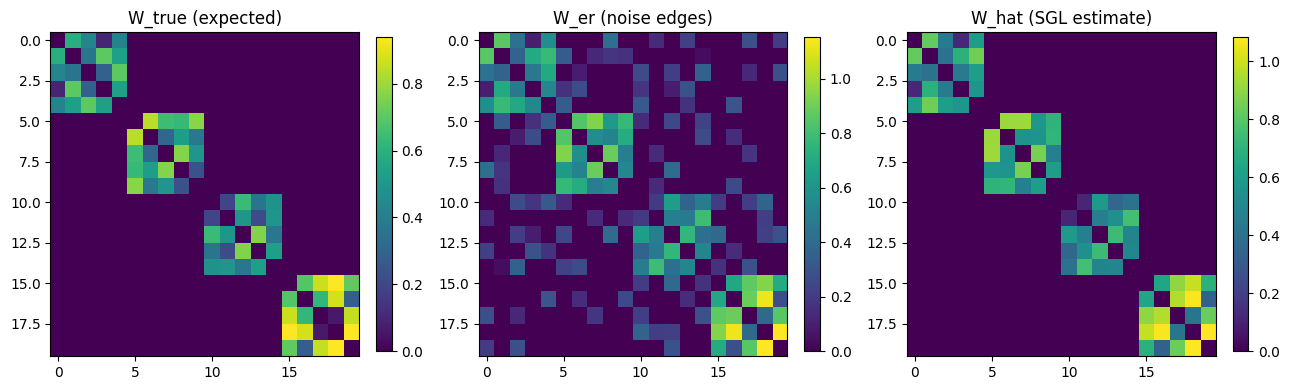

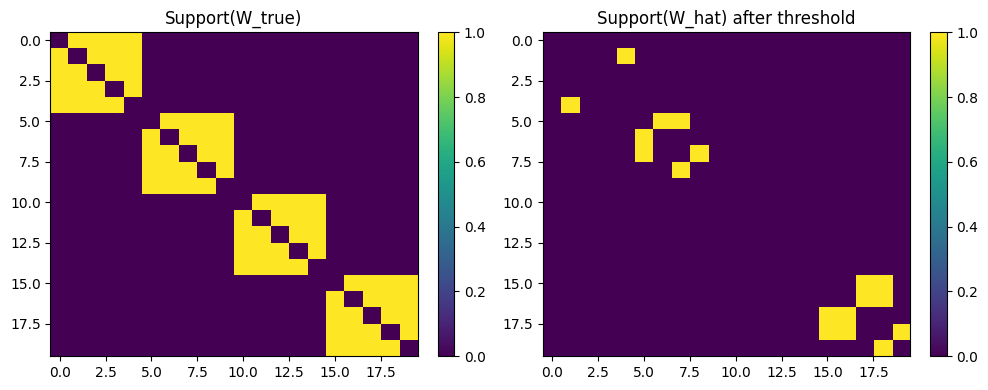

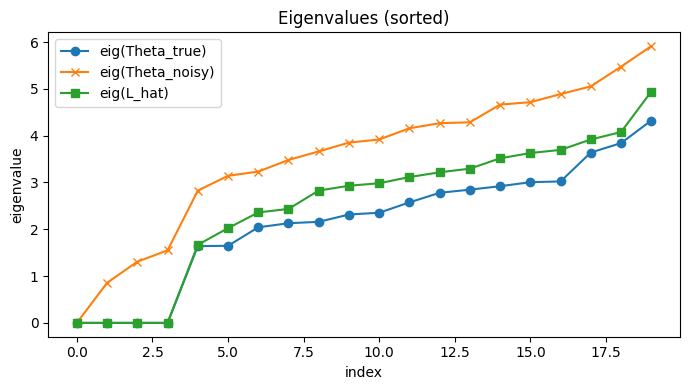

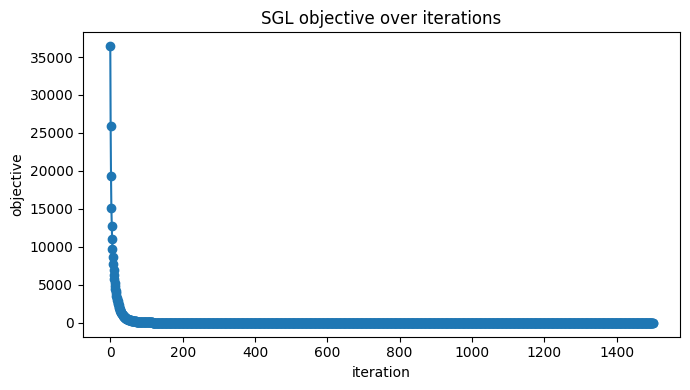

In [138]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 0) Your helpers
# =========================

def laplacian_from_W(W: np.ndarray) -> np.ndarray:
    """Combinatorial Laplacian L = D - W."""
    D = np.diag(W.sum(axis=1))
    return D - W


# =========================
# 1) SGL (learn_k_component_graph) – minimal faithful port
# =========================

def make_edge_index(p: int) -> np.ndarray:
    return np.asarray([(i, j) for i in range(p) for j in range(i + 1, p)], dtype=np.int64)

def L_from_w(w: np.ndarray, p: int, edge_index: np.ndarray) -> np.ndarray:
    L = np.zeros((p, p), dtype=float)
    for e, (i, j) in enumerate(edge_index):
        wij = float(w[e])
        if wij == 0.0:
            continue
        L[i, i] += wij
        L[j, j] += wij
        L[i, j] -= wij
        L[j, i] -= wij
    return L

def A_from_w(w: np.ndarray, p: int, edge_index: np.ndarray) -> np.ndarray:
    A = np.zeros((p, p), dtype=float)
    for e, (i, j) in enumerate(edge_index):
        wij = float(w[e])
        if wij == 0.0:
            continue
        A[i, j] = wij
        A[j, i] = wij
    return A

def Lstar(M: np.ndarray, edge_index: np.ndarray) -> np.ndarray:
    out = np.empty((edge_index.shape[0],), dtype=float)
    for e, (i, j) in enumerate(edge_index):
        out[e] = M[i, i] + M[j, j] - 2.0 * M[i, j]
    return out

def w_from_L_like(M: np.ndarray, edge_index: np.ndarray) -> np.ndarray:
    """Linv-like heuristic used by repo 'naive': w_ij = -M_ij for i<j."""
    w = np.empty((edge_index.shape[0],), dtype=float)
    for e, (i, j) in enumerate(edge_index):
        w[e] = -float(M[i, j])
    return w

def eigval_sym(M: np.ndarray) -> np.ndarray:
    d, _ = np.linalg.eigh(M)
    return d

def eigvec_sym(M: np.ndarray) -> np.ndarray:
    _, V = np.linalg.eigh(M)
    return V

def laplacian_U_update(Lw: np.ndarray, k: int) -> np.ndarray:
    V = eigvec_sym(Lw)         # columns sorted by ascending eigenvalues
    return V[:, k:]            # drop first k eigenvectors (should be ~nullspace)

def laplacian_lambda_update(lb: float, ub: float, beta: float, U: np.ndarray, Lw: np.ndarray, k: int) -> np.ndarray:
    p = Lw.shape[0]
    q = p - k
    d = np.diag(U.T @ Lw @ U)
    lam = 0.5 * (d + np.sqrt(d * d + 4.0 / beta))
    lam = np.clip(lam, lb, ub)
    if np.any(np.diff(lam) < -1e-9):
        raise ValueError("lambda not nondecreasing; increase beta.")
    if lam.shape[0] != q:
        raise RuntimeError("lambda length mismatch")
    return lam

def laplacian_negloglikelihood(Lw: np.ndarray, lam: np.ndarray, K: np.ndarray) -> float:
    return float(np.sum(-np.log(lam)) + np.trace(K @ Lw))

def laplacian_prior(beta: float, Lw: np.ndarray, lam: np.ndarray, U: np.ndarray) -> float:
    ULmdUT = U @ np.diag(lam) @ U.T
    diff = Lw - ULmdUT
    return 0.5 * beta * float(np.sum(diff * diff))  # ||.||_F^2

def laplacian_w_update(w: np.ndarray, Lw: np.ndarray, U: np.ndarray, beta: float,
                       lam: np.ndarray, K: np.ndarray, edge_index: np.ndarray) -> np.ndarray:
    ULmdUT = U @ np.diag(lam) @ U.T
    c = Lstar(ULmdUT - (K / beta), edge_index)

    grad_f = Lstar(Lw, edge_index) - c
    p = Lw.shape[0]
    M_grad_f = Lstar(L_from_w(grad_f, p, edge_index), edge_index)

    wT_M_grad_f = float(np.dot(w, M_grad_f))
    dwT_M_dw = float(np.dot(grad_f, M_grad_f))
    if dwT_M_dw <= 1e-18 or not np.isfinite(dwT_M_dw):
        return np.maximum(w, 0.0)

    t = (wT_M_grad_f - float(np.dot(c, grad_f))) / dwT_M_dw
    return np.maximum(w - t * grad_f, 0.0)

def learn_k_component_graph(
    S: np.ndarray,
    *,
    k: int,
    alpha: float = 0.0,
    beta: float = 1e4,
    lb: float = 0.0,
    ub: float = 1e4,
    eps: float = 1e-4,
    maxiter: int = 2000,
    abstol: float = 1e-6,
    reltol: float = 1e-4,
    record_objective: bool = True,
):
    S = np.asarray(S, float)
    n = S.shape[0]
    edge_index = make_edge_index(n)

    Sinv = np.linalg.pinv(S)
    w = w_from_L_like(Sinv, edge_index)
    w[w < 0.0] = 0.0

    Lw = L_from_w(w, n, edge_index)
    H = alpha * (np.eye(n) - np.ones((n, n)))
    K = S + H

    U = laplacian_U_update(Lw, k=k)
    lam = laplacian_lambda_update(lb, ub, beta, U, Lw, k)

    fun_seq = []
    if record_objective:
        fun_seq.append(laplacian_negloglikelihood(Lw, lam, K) + laplacian_prior(beta, Lw, lam, U))

    for it in range(maxiter):
        w_new = laplacian_w_update(w, Lw, U, beta, lam, K, edge_index)
        Lw_new = L_from_w(w_new, n, edge_index)
        U_new = laplacian_U_update(Lw_new, k=k)
        lam_new = laplacian_lambda_update(lb, ub, beta, U_new, Lw_new, k)

        werr = np.abs(w - w_new)
        has_conv = (np.all(werr <= 0.5 * reltol * (w_new + w)) or np.all(werr <= abstol))

        # repo’s reweighting step:
        denom = (-Lw_new + eps)
        K = S + np.divide(H, denom, out=np.zeros_like(H), where=np.abs(denom) > 0)

        w, Lw, U, lam = w_new, Lw_new, U_new, lam_new

        if record_objective:
            fun_seq.append(laplacian_negloglikelihood(Lw, lam, K) + laplacian_prior(beta, Lw, lam, U))

        if has_conv:
            break

    return {
        "laplacian": Lw,
        "adjacency": A_from_w(w, n, edge_index),
        "w": w,
        "lambda": lam,
        "U": U,
        "obj_fun": np.array(fun_seq) if record_objective else None,
        "iters": it + 1,
    }


# =========================
# 2) Your synthetic generator (block graph + ER noise)
# =========================

rng = np.random.default_rng(0)

p = 20
k_true = 4

sizes = [p // k_true] * k_true
W_true = np.zeros((p, p), dtype=float)

start = 0
for sz in sizes:
    idx = np.arange(start, start + sz)

    A = np.ones((sz, sz), dtype=float)
    np.fill_diagonal(A, 0.0)

    W = rng.uniform(0.0, 1.0, size=(sz, sz))
    W = (W + W.T) / 2
    np.fill_diagonal(W, 0.0)

    W_true[np.ix_(idx, idx)] = A * W
    start += sz

Theta_true = laplacian_from_W(W_true)

kappa = 0.45
p_edge = 0.35

M = (rng.random((p, p)) < p_edge).astype(float)
M = np.triu(M, 1)
M = M + M.T

W_er = rng.uniform(low=0.0, high=kappa, size=(p, p))
W_er = (W_er + W_er.T) / 2
np.fill_diagonal(W_er, 0.0)

W_er = M * W_er
Theta_er = laplacian_from_W(W_er)

Theta_noisy = Theta_true + Theta_er


# =========================
# 3) Turn Theta_noisy into data -> sample covariance S_hat -> run SGL
# =========================

# Theta is a Laplacian-like precision; it's singular (k components). Add jitter for sampling stability.
jitter = 1e-2
Sigma = np.linalg.pinv(Theta_noisy + jitter * np.eye(p))

N = 4000  # number of samples; increase for cleaner recovery
X = rng.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=N)
S_hat = np.cov(X, rowvar=False)

res = learn_k_component_graph(
    S_hat,
    k=k_true,
    alpha=0.0,     # start simple; set >0 later if you want the reweighted sparsity behavior
    beta=1e4,      # spectral penalty; try 1e3..1e5
    maxiter=1500,
    record_objective=True,
)

L_hat = res["laplacian"]
W_hat = res["adjacency"]  # adjacency from learned w


# =========================
# 4) "Expected" vs "Real" plots + quick metrics
# =========================

eig_true = eigval_sym(Theta_true)
eig_noisy = eigval_sym(Theta_noisy)
eig_hat  = eigval_sym(L_hat)

# threshold W_hat to visualize structure (top weights)
if np.any(W_hat > 0):
    thr = np.quantile(W_hat[W_hat > 0], 0.80)  # keep top 20% of positive edges
else:
    thr = 0.0
W_hat_thr = (W_hat >= thr).astype(float)

# ground-truth edge mask (ignore weights; just support)
W_true_bin = (W_true > 0).astype(float)

def upper_tri_vec(M):
    idx = np.triu_indices_from(M, k=1)
    return M[idx]

y_true = upper_tri_vec(W_true_bin)
y_pred = upper_tri_vec(W_hat_thr)

tp = np.sum((y_true == 1) & (y_pred == 1))
fp = np.sum((y_true == 0) & (y_pred == 1))
fn = np.sum((y_true == 1) & (y_pred == 0))
precision = tp / (tp + fp + 1e-12)
recall    = tp / (tp + fn + 1e-12)

print("=== SGL recovery ===")
print("iters:", res["iters"])
print(f"threshold (80% quantile of W_hat>0): {thr:.4g}")
print(f"precision (support): {precision:.3f}")
print(f"recall (support):    {recall:.3f}")
print("smallest eigs true :", np.round(eig_true[:10], 6))
print("smallest eigs noisy:", np.round(eig_noisy[:10], 6))
print("smallest eigs hat  :", np.round(eig_hat[:10], 6))

# Heatmaps: expected (true), noisy, estimated
plt.figure(figsize=(13, 4))

plt.subplot(1, 3, 1)
plt.imshow(W_true, aspect="auto")
plt.title("W_true (expected)")
plt.colorbar(fraction=0.046)

plt.subplot(1, 3, 2)
plt.imshow(W_er + W_true, aspect="auto")
plt.title("W_er (noise edges)")
plt.colorbar(fraction=0.046)

plt.subplot(1, 3, 3)
plt.imshow(W_hat, aspect="auto")
plt.title("W_hat (SGL estimate)")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

# Thresholded structure
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(W_true_bin, aspect="auto")
plt.title("Support(W_true)")
plt.colorbar(fraction=0.046)

plt.subplot(1, 2, 2)
plt.imshow(W_hat_thr, aspect="auto")
plt.title("Support(W_hat) after threshold")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

# Eigenvalue spectra: true vs noisy vs estimated
plt.figure(figsize=(7, 4))
plt.plot(eig_true, marker="o", linestyle="-", label="eig(Theta_true)")
plt.plot(eig_noisy, marker="x", linestyle="-", label="eig(Theta_noisy)")
plt.plot(eig_hat,  marker="s", linestyle="-", label="eig(L_hat)")
plt.title("Eigenvalues (sorted)")
plt.xlabel("index")
plt.ylabel("eigenvalue")
plt.legend()
plt.tight_layout()
plt.show()

# Objective curve
plt.figure(figsize=(7, 4))
plt.plot(res["obj_fun"], marker="o", linestyle="-")
plt.title("SGL objective over iterations")
plt.xlabel("iteration")
plt.ylabel("objective")
plt.tight_layout()
plt.show()
